In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import torch
import torchvision
from PIL import Image

In [2]:
imagesFilepath = "flickr\Flickr_Data\Images"
latent_representation_filepath = "flickr_latent_googleNet.csv"
useCuda = torch.cuda.is_available()
# Load the googlenet pre-trained neural network
encoder = torchvision.models.googlenet(pretrained=True)
encoder.eval()
# Replace the last linear layer (called 'fc') with a dummy identity layer.
# By doing this, we can output the image latent representation
# without messing with the layers naming convention
encoder.fc = torch.nn.Identity()
number_of_latent_variables = 1024 # Can be found by examining googlenet architecture
if useCuda:
    encoder = encoder.cuda()

C:\Users\shippi\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\shippi\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
preprocess = torchvision.transforms.Compose([
            torchvision.transforms.Resize(256),
            torchvision.transforms.CenterCrop(224),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

In [6]:
# Create a list of jpg image filepaths
found_jpg_filepaths = []
directory_contents = os.listdir(imagesFilepath)
for content in directory_contents:
    filepath = os.path.join(imagesFilepath, content)
    if filepath.endswith('.jpg'):
        found_jpg_filepaths.append(filepath)
print(found_jpg_filepaths[0])

flickr\Flickr_Data\Images\1000268201_693b08cb0e.jpg


In [5]:
if not os.path.isfile(latent_representation_filepath): # No need to run it more than once
    with open(latent_representation_filepath, 'w+') as output_file:
        # Write the file header
        output_file.write('filepath')
        for variableNdx in range(number_of_latent_variables):
            output_file.write(",v{}".format(variableNdx))
        output_file.write("\n")

        # Loop through the images
        for index, image_filepath in enumerate(found_jpg_filepaths):
            output_file.write(image_filepath)
            image = Image.open(image_filepath)
            inputTsr = preprocess(image).unsqueeze(0) # Preprocess and add a dummy mini-batch dimension
            if useCuda:
                inputTsr = inputTsr.cuda()
            with torch.no_grad():
                latentTsr = encoder(inputTsr)[0] # Run a forward pass through the encoder and get rid of the dummy mini-batch dimension
                for valueNdx in range(latentTsr.shape[-1]):
                    output_file.write(",{}".format(latentTsr[valueNdx].item()))
                output_file.write("\n")
            if index % 300 == 0:
                print ("{}/{}".format(index, len(found_jpg_filepaths)), end=" ", flush=True)

0/8091 300/8091 600/8091 900/8091 1200/8091 1500/8091 1800/8091 2100/8091 2400/8091 2700/8091 3000/8091 3300/8091 3600/8091 3900/8091 4200/8091 4500/8091 4800/8091 5100/8091 5400/8091 5700/8091 6000/8091 6300/8091 6600/8091 6900/8091 7200/8091 7500/8091 7800/8091 

In [7]:
latent_representationDf = pd.read_csv(latent_representation_filepath)

In [8]:
descriptions_filepath = "flickr\Flickr_Data\Flickr_TextData\Flickr8k.token.txt"
with open(descriptions_filepath, 'r') as file:
    for _ in range(5):  # Display the first 5 lines
        print(file.readline())

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .

1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .

1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .

1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .

1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .



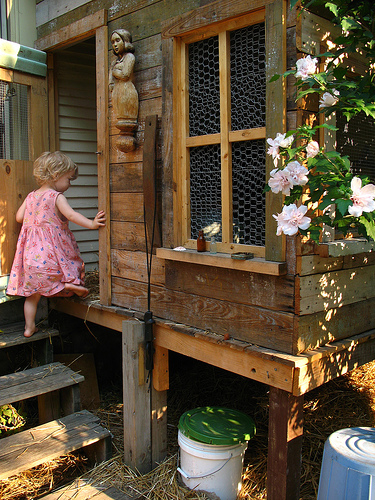

In [9]:
import IPython.display
sample_image_filename = os.path.basename(found_jpg_filepaths[0])
IPython.display.Image(os.path.join(imagesFilepath, sample_image_filename))

In [10]:
training_images_filepath = "flickr\Flickr_Data\Flickr_TextData\Flickr_8k.trainImages.txt"
validation_images_filepath = "flickr\Flickr_Data\Flickr_TextData\Flickr_8k.devImages.txt"
with open(training_images_filepath, 'r') as file:
    for _ in range(5):  # Display the first 5 lines
        print(file.readline())

2513260012_03d33305cf.jpg

2903617548_d3e38d7f88.jpg

3338291921_fe7ae0c8f8.jpg

488416045_1c6d903fe0.jpg

2644326817_8f45080b87.jpg



In [11]:
import en_core_web_sm
import re
import string

nlp = en_core_web_sm.load()

def Tokenize(text, nlp):
    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')  # Remove punctuation and numbers
    nopunct = regex.sub(" ", text.lower())
    tokens = [token.text for token in nlp.tokenizer(nopunct) if not token.text.isspace()]
    return tokens

def TrainDescriptionTokens(descriptions_filepath, train_images_list, nlp):
    number_of_train_lines = 0
    number_of_not_train_lines = 0
    train_token_to_occurrences_dict = {}
    with open(descriptions_filepath, 'r') as descriptions_file:
        for line in descriptions_file:
            line = line.strip()
            sharp_index = line.find('#')
            if sharp_index == -1:
                raise ValueError("TrainDescriptionTokens(): Could not find '#' in line '{}'".format(line))
            image_filename = line[:sharp_index]
            description = line[sharp_index + 3: ]
            if image_filename in train_images_list:
                # Tokenize the description
                tokens = Tokenize(description, nlp)
                for token in tokens:
                    if token in train_token_to_occurrences_dict:
                        train_token_to_occurrences_dict[token] += 1
                    else:
                        train_token_to_occurrences_dict[token] = 1
                number_of_train_lines += 1
            else:
                number_of_not_train_lines += 1
    print("TrainDescriptionTokens(): number_of_train_lines = {}; number_of_not_train_lines = {}".format(number_of_train_lines, number_of_not_train_lines))
    return train_token_to_occurrences_dict

with open(training_images_filepath, 'r') as train_images_file:
    train_images_list = [line.strip() for line in train_images_file]
train_token_to_occurrences_dict = TrainDescriptionTokens(descriptions_filepath, train_images_list, nlp)    

TrainDescriptionTokens(): number_of_train_lines = 30000; number_of_not_train_lines = 10460


In [12]:
print("Before filtering the single occurrences, len(train_token_to_occurrences_dict) = {}".format(len(train_token_to_occurrences_dict)))
single_occurrence_words = []
for word, occurrences in train_token_to_occurrences_dict.items():
    if occurrences < 2:
        single_occurrence_words.append(word)
for word in single_occurrence_words:
    train_token_to_occurrences_dict.pop(word)
print("After filtering the single occurrences, len(train_token_to_occurrences_dict) = {}".format(len(train_token_to_occurrences_dict)))

Before filtering the single occurrences, len(train_token_to_occurrences_dict) = 7331
After filtering the single occurrences, len(train_token_to_occurrences_dict) = 4427


In [13]:
vocabulary_filepath = 'vocabulary_flickr.csv'
sorted_tokens = sorted(train_token_to_occurrences_dict.items(),
                           key=lambda x: x[1], reverse=True)
sorted_tokens = [('ENDOFSEQ', 0), ('UNKNOWN', 0), ('NOTSET', 0)] + sorted_tokens

with open(vocabulary_filepath, 'w+') as output_file:
    output_file.write("index,word,frequency\n")
    for index, token in enumerate(sorted_tokens):
        output_file.write("{},{},{}\n".format(index, token[0], token[1]))

In [14]:
def LoadVocabulary(vocabularyFilepath):
    word_to_index_dict = {}
    index_to_word_dict = {}
    vocabDf = pd.read_csv(vocabularyFilepath)
    for i, row in vocabDf.iterrows():
        index = row['index']
        word = row['word']
        word_to_index_dict[word] = index
        index_to_word_dict[index] = word
    return word_to_index_dict, index_to_word_dict

word_to_index_dict, index_to_word_dict = LoadVocabulary(vocabulary_filepath)
print ("word_to_index_dict['bike'] = {}".format(word_to_index_dict['bike']))

def ConvertTokensListToIndices(tokens, word_to_index_dict, maximum_length):
    indices = [word_to_index_dict['NOTSET']] * maximum_length
    for tokenNdx, token in enumerate(tokens):
        index = word_to_index_dict.get(token, word_to_index_dict['UNKNOWN']) # If the word is not in the dictionary, fall back to 'UNKOWN'
        indices[tokenNdx] = index
    if len(tokens) < maximum_length:
        indices[len(tokens)] = word_to_index_dict['ENDOFSEQ']
    return indices

pretokenized_descriptions_filepath = 'tokenized_descriptions_flickr.csv'
description_maximum_length = 40
with open(pretokenized_descriptions_filepath, 'w+') as outputFile:
    # Write the header
    outputFile.write("image")
    for wordNdx in range(description_maximum_length):
        outputFile.write(",w{}".format(wordNdx))
    outputFile.write("\n")

    # Loop through the lines of the descriptions file
    with open(descriptions_filepath, 'r') as descriptionsFile:
        for line in descriptionsFile:
            line = line.strip()
            sharp_index = line.find('#')
            if sharp_index == -1:
                raise ValueError("Could not find '#' in line '{}'".format(line))
            image_filename = line[:sharp_index]
            description = line[sharp_index + 3:]
            # Tokenize the description
            tokens = Tokenize(description, nlp)

            # Convert the list of tokens to a list of indices
            indices = ConvertTokensListToIndices(tokens,
                                                 word_to_index_dict,
                                                 description_maximum_length)
            outputFile.write(image_filename)
            for indexNdx in range(len(indices)):
                outputFile.write(",{}".format(indices[indexNdx]))
            outputFile.write("\n")    

word_to_index_dict['bike'] = 78


In [15]:
tokenized_descriptionsDf = pd.read_csv(pretokenized_descriptions_filepath)
tokenized_descriptionsDf.head()

,image,w0,w1,w2,w3,w4,w5,w6,w7,w8,...,w30,w31,w32,w33,w34,w35,w36,w37,w38,w39
0,1000268201_693b08cb0e.jpg,3,43,4,3,88,172,7,117,53,...,2,2,2,2,2,2,2,2,2,2
1,1000268201_693b08cb0e.jpg,3,19,316,65,3,197,120,0,2,...,2,2,2,2,2,2,2,2,2,2
2,1000268201_693b08cb0e.jpg,3,40,19,117,65,3,197,2069,0,...,2,2,2,2,2,2,2,2,2,2
3,1000268201_693b08cb0e.jpg,3,40,19,117,5,397,20,61,2069,...,2,2,2,2,2,2,2,2,2,2
4,1000268201_693b08cb0e.jpg,3,40,19,4,3,88,172,316,65,...,2,2,2,2,2,2,2,2,2,2


In [16]:
training_description_indices = []
for t in tokenized_descriptionsDf.itertuples():
    filename = t[1]
    if filename in train_images_list:
        training_description_indices.append(list(t[2:]))
print ("training_description_indices[0:5] = {}".format(training_description_indices[0:5]))

training_description_indices[0:5] = [[3, 43, 4, 3, 88, 172, 7, 117, 53, 3, 390, 12, 397, 4, 28, 1, 629, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [3, 19, 316, 65, 3, 197, 120, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [3, 40, 19, 117, 65, 3, 197, 2069, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [3, 40, 19, 117, 5, 397, 20, 61, 2069, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [3, 40, 19, 4, 3, 88, 172, 316, 65, 3, 197, 2911, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]]


In [17]:
from torch.utils.data import Dataset, DataLoader
import random

class ContextToWordDataset(Dataset):
    def __init__(self,
                 training_descriptions_indices,
                 index_to_word_dict,
                 word_to_index_dict,
                 contextLength):
        self.training_descriptions_indices = training_descriptions_indices
        self.index_to_word_dict = index_to_word_dict
        self.word_to_index_dict = word_to_index_dict
        self.contextLength = contextLength

    def __len__(self):
        return len(self.training_descriptions_indices)
    def __getitem__(self, idx):
        description_indices = self.training_descriptions_indices[idx]
        # Randomly select a target word
        last_acceptable_center_index = len(description_indices) - 1
        # print(last_acceptable_center_index)
        if self.word_to_index_dict['ENDOFSEQ'] in description_indices:
            for position, index in enumerate(description_indices):
                if index == self.word_to_index_dict['ENDOFSEQ'] in description_indices:
                    last_acceptable_center_index = position        
        targetNdx = random.choice(range(last_acceptable_center_index + 1))
        description_indicesTsr = torch.ones((2 * self.contextLength)).long() * self.word_to_index_dict['NOTSET']

        runningNdx = targetNdx - int(self.contextLength)
        counter = 0
        while counter < 2 * self.contextLength:
            if runningNdx != targetNdx:
                if runningNdx >= 0 and runningNdx < len(description_indices):
                    description_indicesTsr[counter] = description_indices[runningNdx]
                counter += 1
            runningNdx += 1
        return (description_indicesTsr, description_indices[targetNdx])
    
train_dataset = ContextToWordDataset(training_description_indices,index_to_word_dict, word_to_index_dict, contextLength=3)

In [18]:
sample_data_0 = train_dataset[0]
sample_words_0 = [index_to_word_dict[i] for i in sample_data_0[0].tolist()]
center_word_0 = index_to_word_dict[sample_data_0[1]]
print ("sample_words_0 = {}; center_word_0 = {}".format(sample_words_0, center_word_0))
sample_data_1 = train_dataset[1]
sample_words_1 = [index_to_word_dict[i] for i in sample_data_1[0].tolist()]
center_word_1 = index_to_word_dict[sample_data_1[1]]
print ("sample_words_1 = {}; center_word_1 = {}".format(sample_words_1, center_word_1))

sample_words_0 = ['NOTSET', 'NOTSET', 'NOTSET', 'child', 'in', 'a']; center_word_0 = a
sample_words_1 = ['into', 'a', 'wooden', 'ENDOFSEQ', 'NOTSET', 'NOTSET']; center_word_1 = building


In [20]:
class CenterWordPredictor(torch.nn.Module):
    def __init__(self, vocabulary_size, embedding_dimension):
        super(CenterWordPredictor, self).__init__()
        self.embedding = torch.nn.Embedding(vocabulary_size, embedding_dimension)
        self.decoderLinear = torch.nn.Linear(embedding_dimension, vocabulary_size)

    def forward(self, contextTsr):
        # contextTsr.shape = (N, context_length), contextTsr.dtype = torch.int64
        embedding = self.embedding(contextTsr)  # (N, context_length, embedding_dimension)
        # Average over context words: (N, context_length, embedding_dimension) -> (N, embedding_dimension)
        embedding = torch.mean(embedding, dim=1)
        # Decoding
        outputTsr = self.decoderLinear(embedding)
        return outputTsr
    
embedding_dimension = 128
word_embedder = CenterWordPredictor(len(word_to_index_dict), embedding_dimension)
if useCuda:
    word_embedder = word_embedder.cuda()

In [19]:
word_embedder_parameters = filter(lambda p: p.requires_grad, word_embedder.parameters())
optimizer = torch.optim.Adam(word_embedder_parameters, lr=0.0001)
lossFcn = torch.nn.CrossEntropyLoss()
train_dataLoader = DataLoader(train_dataset, batch_size=32, shuffle=True)

for epoch in range(1, 1001):
    word_embedder.train()
    loss_sum = 0.0
    number_of_batches = 0
    for (description_indicesTsr, target_center_word_ndx) in train_dataLoader:
        if number_of_batches % 20 == 1:
            print (".", end="", flush=True)
        if useCuda:
            description_indicesTsr = description_indicesTsr.cuda()
            target_center_word_ndx = target_center_word_ndx.cuda()
        predicted_center_word_ndx = word_embedder(description_indicesTsr)
        optimizer.zero_grad()
        loss = lossFcn(predicted_center_word_ndx, target_center_word_ndx)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
        number_of_batches += 1
    train_loss = loss_sum/number_of_batches
    print ("\nepoch {}: train_loss = {}".format(epoch, train_loss))

...............................................
epoch 1: train_loss = 2.768509477567571
...........

KeyboardInterrupt: 

In [21]:
words2vec_dictionary_filepath = 'words2vec/flickr_words2vec.csv'
with open(words2vec_dictionary_filepath, 'w+') as word2vecFile:
        # Write the header
        word2vecFile.write("word")
        for embeddingNdx in range(embedding_dimension):
            word2vecFile.write(",e{}".format(embeddingNdx))
        word2vecFile.write("\n")

        for index, word in index_to_word_dict.items():
            wordEmbeddingList = word_embedder.embedding.weight[index].tolist()
            word2vecFile.write(word)
            for coef in wordEmbeddingList:
                word2vecFile.write(",{}".format(str(coef)))
            word2vecFile.write("\n")

In [22]:
word2vecDf = pd.read_csv(words2vec_dictionary_filepath)
word_to_embedding_dict = {word2vecDf.iloc[i]['word'] : word2vecDf.loc[i, 'e0': 'e{}'.format(embedding_dimension - 1)].tolist()
                              for i in range(len(word2vecDf))}

In [23]:
print ("word_to_embedding_dict['dog'] = {}".format(word_to_embedding_dict['dog']))

word_to_embedding_dict['dog'] = [-0.2673083543777466, 1.6066317558288574, 1.5448455810546875, 0.935874044895172, 1.2329177856445312, -2.1145753860473637, -0.4946054518222809, 1.398156762123108, 0.5678762793540955, 0.0305077955126762, 0.1940225064754486, 0.4359626173973083, 1.3881237506866455, -0.7461925745010376, -1.8110833168029783, 2.126912832260132, -0.2401591688394546, 1.0774410963058472, -1.9103535413742063, 1.623495101928711, -1.3474557399749756, 0.0816679447889328, 0.5013593435287476, 1.0767593383789062, -0.208948016166687, -0.7157616019248962, 0.4462305009365082, -0.9779099225997924, -0.0602063797414302, -1.3157131671905518, -0.4142844974994659, 0.1099332123994827, 0.549610435962677, -0.40670046210289, -1.0336387157440186, 1.7179967164993286, 1.0556492805480957, 0.0703755617141723, 0.7589284777641296, 2.034387350082397, 0.3446714878082275, -0.0912784487009048, 1.37116277217865, 0.829896092414856, 1.391461968421936, -1.9841880798339844, -0.3431430459022522, -1.4098625183105469, 

In [24]:
class CaptionGenerationDataset(Dataset):
    def __init__(self,
                 image_filenames,
                 image_filename_to_latent_variables,
                 image_filename_to_tokenized_descriptions_list,
                 endOfSeqIndex,
                 notSetIndex,
                 vocabulary_size,
                 index_to_word_dict,
                 word_to_embedding_dict
                 ):
        self.image_filenames = image_filenames
        self.image_filename_to_latent_variables = image_filename_to_latent_variables
        self.image_filename_to_tokenized_descriptions_list = image_filename_to_tokenized_descriptions_list
        self.endOfSeqIndex = endOfSeqIndex
        self.notSetIndex = notSetIndex
        self.vocabulary_size = vocabulary_size
        self.index_to_word_dict = index_to_word_dict
        self.word_to_embedding_dict = word_to_embedding_dict

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        if idx >= len(self.image_filenames):
            raise IndexError("CaptionGenerationDataset.__getitem__(): Index {} is greater than the number of images ({})".format(idx, len(self.image_filenames)))
        filename = self.image_filenames[idx]
        latent_variables = self.image_filename_to_latent_variables[filename]
        # Build a tensor
        latent_variablesTsr = torch.zeros(len(latent_variables))
        for i in range(len(latent_variables)):
            latent_variablesTsr[i] = latent_variables[i]
        # Randomly choose one of the descriptions
        description = random.choice(self.image_filename_to_tokenized_descriptions_list[filename])
        lastIndex = self.IndexOfEndOfSeq(description)
        chopIndex = random.randint(0, lastIndex) - 1 # The last index of the chopped description
        choppedDescription = [self.notSetIndex] * len(description)
        if chopIndex >= 0:
            for i in range(chopIndex + 1):
                choppedDescription[i] = description[i]

        embedding_dim = len(self.word_to_embedding_dict[ self.index_to_word_dict[0] ]) # Length of the embedding of the 1st word
        embeddedChoppedDescriptionTsr = torch.zeros((len(description), embedding_dim))
        for wordPosn in range(len(choppedDescription)):
            embedding = self.word_to_embedding_dict[ self.index_to_word_dict[choppedDescription[wordPosn]]]
            embeddedChoppedDescriptionTsr[wordPosn] = torch.tensor(embedding)

        next_word_index = description[chopIndex + 1]

        return ( (latent_variablesTsr, embeddedChoppedDescriptionTsr), next_word_index)

    def IndexOfEndOfSeq(self, description_list):
        foundIndex = -1
        for candidateNdx in range(len(description_list)):
            if description_list[candidateNdx] == self.endOfSeqIndex:
                foundIndex = candidateNdx
                break
        if foundIndex == -1:
            return len(description_list) - 1
        else:
            return foundIndex
        
def ImageFilenameToLatentVariables(latent_varDf):
    image_filename_to_latent_variables = {}
    for i, row in latent_varDf.iterrows():
        filepath = latent_varDf.iloc[i][0]
        filename = os.path.basename(filepath)
        latent_variables = list(latent_varDf.iloc[i][1:])
        image_filename_to_latent_variables[filename] = latent_variables
    return image_filename_to_latent_variables

image_filename_to_latent_variables = ImageFilenameToLatentVariables(latent_representationDf)

def ImageFilenameToTokenizedDescriptionsList(descriptionsDF):
    image_filename_to_tokenized_description = {}
    for i, row in descriptionsDF.iterrows():
        filename = descriptionsDF.iloc[i][0]
        tokenized_description = list(descriptionsDF.iloc[i][1:])
        if filename in image_filename_to_tokenized_description:
            image_filename_to_tokenized_description[filename].append(tokenized_description)
        else:
            image_filename_to_tokenized_description[filename] = [tokenized_description]
    return image_filename_to_tokenized_description

image_filename_to_tokenized_descriptions_list = ImageFilenameToTokenizedDescriptionsList(tokenized_descriptionsDf)

lstm_train_dataset = CaptionGenerationDataset(
        train_images_list,
        image_filename_to_latent_variables,
        image_filename_to_tokenized_descriptions_list,
        word_to_index_dict['ENDOFSEQ'],
        word_to_index_dict['NOTSET'],
        len(word_to_index_dict),
        index_to_word_dict,
        word_to_embedding_dict
    )

In [25]:
with open(validation_images_filepath, 'r') as valid_images_file:
    validation_images_list = [line.strip() for line in valid_images_file]
lstm_validation_dataset = CaptionGenerationDataset(
        validation_images_list,
        image_filename_to_latent_variables,
        image_filename_to_tokenized_descriptions_list,
        word_to_index_dict['ENDOFSEQ'],
        word_to_index_dict['NOTSET'],
        len(word_to_index_dict),
        index_to_word_dict,
        word_to_embedding_dict
    )

In [26]:
class LSTM_fixed_embedding(torch.nn.Module):
    def __init__(self, embedding_dim, lstm_hidden_dim,
                 num_lstm_layers, image_latent_dim,
                 vocab_size,
                 dropoutProportion=0.5):
        super(LSTM_fixed_embedding, self).__init__()
        self.embedding_dim = embedding_dim
        self.lstm = torch.nn.LSTM(embedding_dim, lstm_hidden_dim, num_lstm_layers, batch_first=True)
        self.dropout = torch.nn.Dropout(dropoutProportion)
        self.linear = torch.nn.Linear(lstm_hidden_dim + image_latent_dim, vocab_size)


    def forward(self, image_latentTsr, embeddedChoppedDescriptionTsr):
        aggregated_h, (ht, ct) = self.lstm(embeddedChoppedDescriptionTsr)
        concat_latent = torch.cat( (torch.nn.functional.normalize(ht[-1]), torch.nn.functional.normalize(image_latentTsr)), dim=1)
        outputTsr = self.linear(self.dropout(concat_latent))
        return outputTsr
    
    
    def Caption(self, latentVariablesTsr, maximumLength, word_to_embedding_dict, index_to_word_dict, endOfSeqIndex, useCuda):
        notSetEmbedding = word_to_embedding_dict['NOTSET']
        embeddedChoppedDescriptionTsr = torch.zeros((maximumLength, self.embedding_dim))
        for i in range(maximumLength):
            embeddedChoppedDescriptionTsr[i] = torch.tensor(notSetEmbedding)
        endOfSeqIsFound = False
        runningNdx = 0
        caption_words = []
        while not endOfSeqIsFound and runningNdx < maximumLength:
            if useCuda:
                latentVariablesTsr = latentVariablesTsr.cuda()
                embeddedChoppedDescriptionTsr = embeddedChoppedDescriptionTsr.cuda()
            outputTsr = self.forward(latentVariablesTsr.unsqueeze(0), embeddedChoppedDescriptionTsr.unsqueeze(0))
            next_word_index = torch.argmax(outputTsr[0]).item()
            caption_words.append(index_to_word_dict[next_word_index])
            next_word = index_to_word_dict[next_word_index]
            embeddedChoppedDescriptionTsr[runningNdx] = torch.tensor(word_to_embedding_dict[next_word])
            runningNdx += 1
            if next_word_index == endOfSeqIndex:
                endOfSeqIsFound = True
        return caption_words

lstm_hidden_dimension = 32
lstm_number_of_layers = 2
dropoutProportion = 0.5
lstm_model = LSTM_fixed_embedding(
        embedding_dim=embedding_dimension,
        lstm_hidden_dim=lstm_hidden_dimension,
        num_lstm_layers=lstm_number_of_layers,
        image_latent_dim=number_of_latent_variables,
        vocab_size=len(word_to_index_dict),
        dropoutProportion=dropoutProportion
    )

if useCuda:
    lstm_model = lstm_model.cuda()

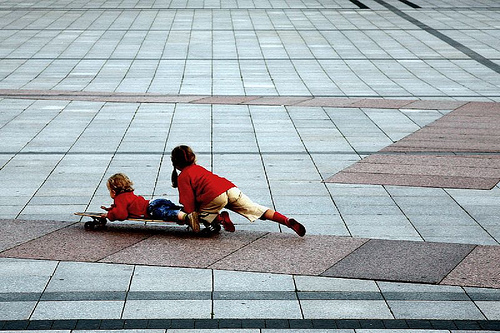

In [27]:
def TestSample(index, validation_images_list, image_filename_to_latent_variables, model,
               index_to_word_dict,
               word_to_embedding_dict,
               sequence_length=40,
               endOfSeqIndex=0,
               useCuda=True):
    sample_filename = validation_images_list[index]
    sample_latentVariablesTsr = torch.FloatTensor(image_filename_to_latent_variables[sample_filename])
    if useCuda:
        sample_latentVariablesTsr = sample_latentVariablesTsr.cuda()
    sample_words = model.Caption(
        latentVariablesTsr=sample_latentVariablesTsr,
        maximumLength=sequence_length,
        word_to_embedding_dict=word_to_embedding_dict,
        index_to_word_dict=index_to_word_dict,
        endOfSeqIndex=endOfSeqIndex,
        useCuda=useCuda
    )
    return sample_words

validation_sample_0_Ndx = 0
validation_sample_100_Ndx = 100
IPython.display.Image(os.path.join(imagesFilepath, validation_images_list[validation_sample_0_Ndx]))

In [31]:
best_model_filepath = 'lstm_gnet_flickr.pth'

In [ ]:
import sys

parameters = filter(lambda p: p.requires_grad, lstm_model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.0003)
lossFcn = torch.nn.CrossEntropyLoss()
train_dataLoader = DataLoader(lstm_train_dataset, batch_size=16, shuffle=True)
validation_dataLoader = DataLoader(lstm_validation_dataset, batch_size=lstm_validation_dataset.__len__())
# best_model_filepath = 'lstm_gnet_flickr.pth'

lowestValidationLoss = 3.2205240726470947
for epoch in range(1, 500 + 1):
    lstm_model.train()
    loss_sum = 0.0
    numberOfBatches = 0
    for ( (latent_variablesTsr, chopped_descriptionTsr), target_next_word) in train_dataLoader:
        if numberOfBatches % 4 == 1:
            print (".", end="", flush=True)
        if useCuda:
            latent_variablesTsr = latent_variablesTsr.cuda()
            chopped_descriptionTsr = chopped_descriptionTsr.cuda()
            target_next_word = target_next_word.cuda()
        predicted_next_word = lstm_model(latent_variablesTsr, chopped_descriptionTsr)
        optimizer.zero_grad()
        loss = lossFcn(predicted_next_word, target_next_word)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
        numberOfBatches += 1
    train_loss = loss_sum/numberOfBatches
    print ("\nepoch {}: train_loss = {}".format(epoch, train_loss))

    # Validation
    lstm_model.eval()
    sample_0_words = TestSample(validation_sample_0_Ndx, validation_images_list, image_filename_to_latent_variables, lstm_model,
       index_to_word_dict,
       word_to_embedding_dict,
       sequence_length=40,
       endOfSeqIndex=0,
       useCuda=useCuda)
    print ("sample_0_words = {}".format(sample_0_words))
    sample_100_words = TestSample(validation_sample_100_Ndx, validation_images_list, image_filename_to_latent_variables, lstm_model,
       index_to_word_dict,
       word_to_embedding_dict,
       sequence_length=40,
       endOfSeqIndex=0,
       useCuda=useCuda)
    print ("sample_100_words = {}".format(sample_100_words))
    
    for ((validation_latent_variablesTsr, validation_chopped_descriptionTsr), validation_target_next_word) in validation_dataLoader:
        if useCuda:
            validation_latent_variablesTsr = validation_latent_variablesTsr.cuda()
            validation_chopped_descriptionTsr = validation_chopped_descriptionTsr.cuda()
            validation_target_next_word = validation_target_next_word.cuda()
        validation_predicted_next_word = lstm_model(validation_latent_variablesTsr, validation_chopped_descriptionTsr)
        validation_loss = lossFcn(validation_predicted_next_word, validation_target_next_word).item()
    print ("validation_loss = {}".format(validation_loss))

    if validation_loss < lowestValidationLoss:
        lowestValidationLoss = validation_loss
        torch.save(lstm_model.state_dict(), best_model_filepath)

..............................................................................................
epoch 1: train_loss = 7.132757403055827
sample_0_words = ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']
sample_100_words = ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']
validation_loss = 5.935925006866455
..............................................................................................
epoch 2: train_loss = 5.628935746510823
sample_0_words = ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']
sample_100_words = ['a', 'a', 'a', 'a'

sample_100_words = ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']
validation_loss = 5.260830879211426
..............................................................................................
epoch 15: train_loss = 5.2155409495035805
sample_0_words = ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']
sample_100_words = ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']
validation_loss = 5.102413654327393
..............................................................................................
epoch 16: train_loss = 5.1796316884358

validation_loss = 4.590867042541504
..............................................................................................
epoch 41: train_loss = 4.66675532023112
sample_0_words = ['a', 'man', 'ENDOFSEQ']
sample_100_words = ['a', 'man', 'ENDOFSEQ']
validation_loss = 4.781824111938477
..............................................................................................
epoch 42: train_loss = 4.795889680862427
sample_0_words = ['a', 'man', 'ENDOFSEQ']
sample_100_words = ['a', 'man', 'ENDOFSEQ']
validation_loss = 4.65462589263916
..............................................................................................
epoch 43: train_loss = 4.724064748128256
sample_0_words = ['a', 'man', 'ENDOFSEQ']
sample_100_words = ['a', 'man', 'ENDOFSEQ']
validation_loss = 4.596404552459717
..............................................................................................
epoch 44: train_loss = 4.755317461649577
sample_0_words = ['a', 'man', 'in', 'a', 'in', 'ENDOFSEQ

validation_loss = 4.123126983642578
..............................................................................................
epoch 92: train_loss = 4.198973054250081
sample_0_words = ['a', 'man', 'in', 'a', 'red', 'is', 'is', 'in', 'a', 'red', 'ENDOFSEQ']
sample_100_words = ['a', 'man', 'in', 'a', 'player', 'in', 'a', 'ball', 'ENDOFSEQ']
validation_loss = 4.033173084259033
..............................................................................................
epoch 93: train_loss = 4.218973291397095
sample_0_words = ['a', 'man', 'in', 'a', 'man', 'in', 'a', 'red', 'is', 'is', 'is', 'in', 'a', 'red', 'ENDOFSEQ']
sample_100_words = ['a', 'man', 'in', 'a', 'player', 'in', 'a', 'ball', 'ENDOFSEQ']
validation_loss = 4.291368007659912
..............................................................................................
epoch 94: train_loss = 4.105806197484334
sample_0_words = ['a', 'man', 'in', 'a', 'boy', 'in', 'a', 'red', 'boy', 'in', 'a', 'red', 'boy', 'in', 'a', 're

..............................................................................................
epoch 137: train_loss = 3.8916955658594765
sample_0_words = ['a', 'man', 'on', 'a', 'red', 'shirt', 'is', 'is', 'on', 'a', 'red', 'ENDOFSEQ']
sample_100_words = ['a', 'man', 'in', 'a', 'player', 'player', 'on', 'a', 'ball', 'ENDOFSEQ']
validation_loss = 3.9944052696228027
..............................................................................................
epoch 138: train_loss = 3.9435815137227377
sample_0_words = ['a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'is', 'on', 'a', 'red', 'red', 'ENDOFSEQ']
sample_100_words = ['a', 'man', 'in', 'a', 'player', 'player', 'on', 'a', 'ball', 'ENDOFSEQ']
validation_loss = 4.14368200302124
..............................................................................................
epoch 139: train_loss = 3.941464079538981
sample_0_words = ['a', 'man', 'is', 'is', 'on', 'a', 'red', 'shirt', 'is', 'is', 'on', 'a', 'red', 'red', 'ENDOFSEQ']
samp

..............................................................................................
epoch 181: train_loss = 3.7400496864318846
sample_0_words = ['a', 'boy', 'in', 'a', 'red', 'shirt', 'is', 'is', 'in', 'a', 'red', 'shirt', 'ENDOFSEQ']
sample_100_words = ['a', 'man', 'in', 'a', 'player', 'in', 'a', 'player', 'in', 'a', 'player', 'ENDOFSEQ']
validation_loss = 3.8422608375549316
..............................................................................................
epoch 182: train_loss = 3.7006070569356284
sample_0_words = ['a', 'boy', 'in', 'a', 'red', 'shirt', 'is', 'is', 'on', 'a', 'red', 'ENDOFSEQ']
sample_100_words = ['a', 'man', 'in', 'a', 'player', 'player', 'in', 'a', 'ball', 'ENDOFSEQ']
validation_loss = 3.9400012493133545
..............................................................................................
epoch 183: train_loss = 3.7566514155069988
sample_0_words = ['a', 'boy', 'is', 'is', 'on', 'a', 'red', 'shirt', 'on', 'a', 'red', 'ENDOFSEQ']
sampl

validation_loss = 3.834123373031616
..............................................................................................
epoch 225: train_loss = 3.6597502829233806
sample_0_words = ['a', 'boy', 'in', 'a', 'red', 'shirt', 'is', 'is', 'on', 'a', 'red', 'ENDOFSEQ']
sample_100_words = ['a', 'man', 'in', 'a', 'player', 'in', 'a', 'player', 'ENDOFSEQ']
validation_loss = 3.830895185470581
..............................................................................................
epoch 226: train_loss = 3.613852728207906
sample_0_words = ['a', 'boy', 'is', 'is', 'is', 'on', 'a', 'skateboard', 'ENDOFSEQ']
sample_100_words = ['a', 'man', 'is', 'playing', 'on', 'a', 'ball', 'ENDOFSEQ']
validation_loss = 3.6700260639190674
..............................................................................................
epoch 227: train_loss = 3.639687537829081
sample_0_words = ['a', 'boy', 'on', 'a', 'red', 'shirt', 'is', 'playing', 'on', 'a', 'skateboard', 'ENDOFSEQ']
sample_100_words =

In [29]:
test_images_filepath = 'flickr/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'
with open(test_images_filepath, 'r') as test_images_file:
    test_images_list = [line.strip() for line in test_images_file]
print("lowest validation loss = {}".format(lowestValidationLoss))
print ("len(test_images_list) = {}".format(len(test_images_list)))

len(test_images_list) = 1000


In [35]:
# Load the model that gave the lowest validation loss
lstm_model.load_state_dict(torch.load(best_model_filepath))
# Randomly select some test images
test_image_sample_indices = random.choices(range(len(test_images_list)), k=3)
lstm_model.eval()
test_sample_filepaths = []
test_sample_captions = []
for test_image_sample_index in test_image_sample_indices:
    sample_words = TestSample(test_image_sample_index, test_images_list, image_filename_to_latent_variables, lstm_model,
       index_to_word_dict,
       word_to_embedding_dict,
       sequence_length=40,
       endOfSeqIndex=0,
       useCuda=useCuda)
    caption = ' '.join(sample_words)
    test_sample_filepaths.append(os.path.join(imagesFilepath, test_images_list[test_image_sample_index]))
    test_sample_captions.append(caption)

In [ ]:
print (test_sample_captions[0])
IPython.display.Image(test_sample_filepaths[0])

In [39]:
import nltk
import csv
from nltk.translate.bleu_score import sentence_bleu
from collections import defaultdict


# Load tokenized descriptions
tokenized_descriptions = defaultdict(list)
with open(pretokenized_descriptions_filepath, 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header row
    for row in reader:
        image_name = row[0]
        caption_indices = []
        for index_str in row[1:]:
            index = int(index_str)
            if index == 2:
                break  # Stop capturing indices when index is 2
            caption_indices.append(index)
        tokenized_descriptions[image_name].append(caption_indices)

In [41]:
# Function to convert indices to words
def indices_to_words(indices):
    return [index_to_word_dict[index] for index in indices]

# Calculate BLEU score for each test image
total_bleu_score_1 = 0
total_bleu_score_2 = 0
total_bleu_score_3 = 0
total_bleu_score_4 = 0
total_images = len(test_images_list)
lstm_model.eval()
test_image_sample_indices_all = len(test_images_list);

for index in  range(test_image_sample_indices_all):
     sample_words = TestSample(index, test_images_list, image_filename_to_latent_variables, lstm_model,
       index_to_word_dict,
       word_to_embedding_dict,
       sequence_length=40,
       endOfSeqIndex=0,
       useCuda=useCuda)
     description = ' '.join(sample_words)
     candidate_caption = Tokenize(description, nlp)

     reference_captions = [indices_to_words(indices) for indices in tokenized_descriptions[test_images_list[index]]]

     bleu_score_1 = sentence_bleu(reference_captions, candidate_caption, weights=(1, 0, 0, 0))
     bleu_score_2 = sentence_bleu(reference_captions, candidate_caption, weights=(0.5, 0.5, 0, 0))
     bleu_score_3 = sentence_bleu(reference_captions, candidate_caption, weights=(0.33, 0.33, 0.33, 0))
     bleu_score_4 = sentence_bleu(reference_captions, candidate_caption, weights=(0.25, 0.25, 0.25, 0.25))
    
     total_bleu_score_1 += bleu_score_1
     total_bleu_score_2 += bleu_score_2
     total_bleu_score_3 += bleu_score_3
     total_bleu_score_4 += bleu_score_4

average_bleu_score_1 = total_bleu_score_1 / total_images
average_bleu_score_2 = total_bleu_score_2 / total_images
average_bleu_score_3 = total_bleu_score_3 / total_images
average_bleu_score_4 = total_bleu_score_4 / total_images

# average_bleu_score = total_bleu_score / len(test_images)
print("Average BLEU-1 score:", average_bleu_score_1)
print("Average BLEU-2 score:", average_bleu_score_2)
print("Average BLEU-3 score:", average_bleu_score_3)
print("Average BLEU-4 score:", average_bleu_score_4)


Average BLEU-1 score: 0.5125574933996119
Average BLEU-2 score: 0.3231883563312253
Average BLEU-3 score: 0.13785811579538154
Average BLEU-4 score: 0.04515516928289819
